In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.signal import detrend
import time
import gc
import copy

file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}

pearson_results = copy.deepcopy(structure)
pearson_errors = copy.deepcopy(structure)

def preprocess(data):
    data = detrend(data, axis=0)
    epsilon = 1e-9
    data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
    return data

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted


    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    left_indices = np.where(np.isin(relevant, left_indices_agg))[0]   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    right_indices = np.where(np.isin(relevant, right_indices_agg))[0]

    print(left_indices[0:10])
    print(right_indices[0:10])

    #print(f' found data for left {class_left}, right {class_right}')
    left_input_LFP_attleft = left_input_LFP[left_indices, 100:350]
    right_input_LFP_attleft = right_input_LFP[left_indices, 100:350]
    attention_LFP_attleft = attention_LFP[left_indices, 100:350]

    left_input_LFP_attright = left_input_LFP[right_indices, 100:350]
    right_input_LFP_attright = right_input_LFP[right_indices, 100:350]
    attention_LFP_attright = attention_LFP[right_indices, 100:350]

     #----------------no preprocessing--------------------------------
    left_attleft_pearson = []
    right_attleft_pearson = []
    left_attright_pearson = []
    right_attright_pearson = []

    for i in range(len(left_input_LFP_attleft)):
        left_attleft_pearson.append(pearsonr(left_input_LFP_attleft[i], attention_LFP_attleft[i])[0])
        right_attleft_pearson.append(pearsonr(right_input_LFP_attleft[i], attention_LFP_attleft[i])[0])

    for i in range(len(left_input_LFP_attright)):
        left_attright_pearson.append(pearsonr(left_input_LFP_attright[i], attention_LFP_attright[i])[0])
        right_attright_pearson.append(pearsonr(right_input_LFP_attright[i], attention_LFP_attright[i])[0])
    
    mean_left_attleft = np.mean(left_attleft_pearson)
    mean_right_attleft = np.mean(right_attleft_pearson)
    mean_left_attright = np.mean(left_attright_pearson)
    mean_right_attright = np.mean(right_attright_pearson)

    std_left_attleft = np.std(left_attleft_pearson)
    std_right_attleft = np.std(right_attleft_pearson)
    std_left_attright = np.std(left_attright_pearson)
    std_right_attright = np.std(right_attright_pearson)

    sem_left_attleft = std_left_attleft / np.sqrt(len(left_attleft_pearson))
    sem_right_attleft = std_right_attleft / np.sqrt(len(right_attleft_pearson))
    sem_left_attright = std_left_attright / np.sqrt(len(left_attright_pearson))
    sem_right_attright = std_right_attright / np.sqrt(len(right_attright_pearson))
    
    pearson_results[f'dataset_{file_number}']['left_attleft'] = (mean_left_attleft)
    pearson_results[f'dataset_{file_number}']['right_attleft'] = (mean_right_attleft)
    pearson_results[f'dataset_{file_number}']['left_attright'] = (mean_left_attright)
    pearson_results[f'dataset_{file_number}']['right_attright'] = (mean_right_attright)

    pearson_errors[f'dataset_{file_number}']['left_attleft'] = (sem_left_attleft)
    pearson_errors[f'dataset_{file_number}']['right_attleft'] = (sem_right_attleft)
    pearson_errors[f'dataset_{file_number}']['left_attright'] = (sem_left_attright)
    pearson_errors[f'dataset_{file_number}']['right_attright'] = (sem_right_attright)

    
    del left_input_LFP_attleft, right_input_LFP_attleft, attention_LFP_attleft, left_input_LFP_attright, right_input_LFP_attright, attention_LFP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)
print(pearson_results)
print(pearson_errors)


Dataset 1 loaded in 19.45 seconds
[ 0  1  2  6  9 10 11 12 13 14]
[ 3  4  5  7  8 15 18 20 21 22]
Dataset 1 complete in 22.936139345169067
Dataset 2 loaded in 10.44 seconds
[ 0  6  9 10 11 12 13 14 17 19]
[ 1  2  3  4  5  7  8 15 16 18]
Dataset 2 complete in 11.82766842842102
Dataset 4 loaded in 7.97 seconds
[ 0  2  4  5  6  7 10 13 15 16]
[ 1  3  8  9 11 12 14 20 23 24]
Dataset 4 complete in 9.258301734924316
Dataset 8 loaded in 6.27 seconds
[ 0  6  7  8  9 12 13 14 15 17]
[ 1  2  3  4  5 10 11 16 18 20]
Dataset 8 complete in 7.5257954597473145
Dataset 14 loaded in 5.24 seconds
[ 2  3  5  6  9 11 12 13 14 15]
[ 0  1  4  7  8 10 16 17 19 20]
Dataset 14 complete in 6.294883489608765
Dataset 15 loaded in 4.94 seconds
[ 0  1  2  4  6  8  9 10 12 13]
[ 3  5  7 11 15 16 17 18 19 20]
Dataset 15 complete in 6.207287549972534
Dataset 20 loaded in 5.66 seconds
[ 0  4  7 12 13 18 20 21 22 25]
[ 1  2  3  5  6  8  9 10 11 14]
Dataset 20 complete in 6.836148738861084
Dataset 23 loaded in 5.21 secon

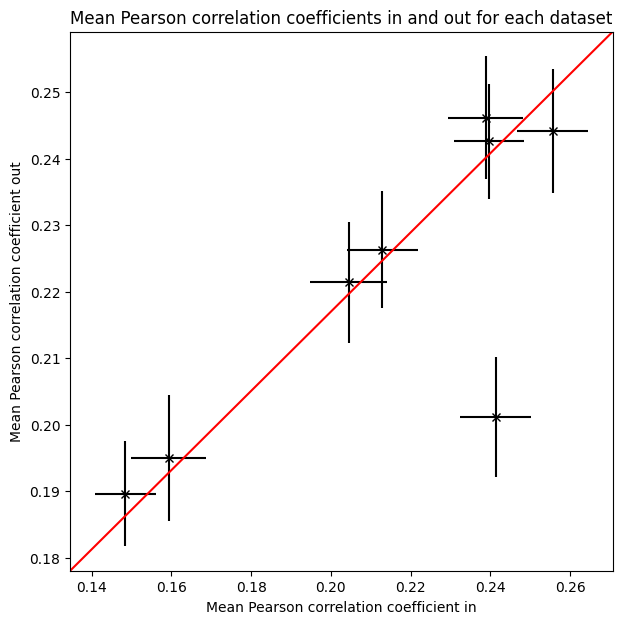

In [3]:

#want a single plot, where for each dataset, mean pearson in and mean pearson out are plotted with error bars
pearson_in = []
pearson_out = []
errors_in = []
errors_out = []

for file_number in file_numbers:
    values = []
    errors = []
    for condition in ['left_attleft', 'right_attright']:
        values.append(pearson_results[f'dataset_{file_number}'][condition])
        errors.append(pearson_errors[f'dataset_{file_number}'][condition])
    pearson_in.append(np.mean(values))
    errors_in.append(np.mean(errors))


    values = []
    errors = []
    for condition in ['left_attright', 'right_attleft']:
        values.append(pearson_results[f'dataset_{file_number}'][condition])
        errors.append(pearson_errors[f'dataset_{file_number}'][condition])
    pearson_out.append(np.mean(values))
    errors_out.append(np.mean(errors))



plt.figure(figsize=(7,7))
plt.errorbar(pearson_in, pearson_out, xerr=errors_in, yerr=errors_out, fmt='x', color = 'k')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'r')
plt.xlabel('Mean Pearson correlation coefficient in')
plt.ylabel('Mean Pearson correlation coefficient out')
plt.title('Mean Pearson correlation coefficients in and out for each dataset')
plt.show()

